In [18]:
import open3d as o3d
import numpy as np
from pyntcloud import PyntCloud

In [53]:
def load_point_clouds(voxel_size=0.0):
    pcds = []
    voxel_size = 0.02
    max_correspondence_distance_coarse = voxel_size*15
    max_correspondence_distance_fine = voxel_size*1.5
    pcd = o3d.io.read_point_cloud("airplane.ply" )
    pcd2 = o3d.io.read_point_cloud("top3.ply" )
    #pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)
    #pcd_down2 = pcd2.voxel_down_sample(voxel_size=voxel_size)
    pcd_down = o3d.geometry.voxel_down_sample(pcd, voxel_size = voxel_size)
    pcd_down2 = o3d.geometry.voxel_down_sample(pcd2, voxel_size = voxel_size)
    pcds.append(pcd_down)
    pcds.append(pcd_down2)
    
    #for i in range(3):
        #pcd = o3d.io.read_point_cloud("../../TestData/ICP/cloud_bin_%d.pcd" % i)
        #pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)
        #pcds.append(pcd_down)
    return pcds

In [54]:
pcds = []
voxel_size = 0.02
max_correspondence_distance_coarse = voxel_size*15
max_correspondence_distance_fine = voxel_size*1.5
pcd = o3d.io.read_point_cloud("top2.ply" )
pcd2 = o3d.io.read_point_cloud("top3.ply" )
#pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)
pcd_down = o3d.geometry.voxel_down_sample(pcd, voxel_size = voxel_size)
#pcd_down2 = pcd2.voxel_down_sample(voxel_size=voxel_size)
pcd_down2 = o3d.geometry.voxel_down_sample(pcd2, voxel_size = voxel_size)
pcds.append(pcd_down)
pcds.append(pcd_down2)

In [64]:
pcd = o3d.io.read_point_cloud("../../TestData/fragment.ply")
o3d.visualization.draw_geometries([pcd])

geometry::PointCloud with 0 points.
PyntCloud
1335 points with 0 scalar fields
2452 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 896.99365234375, 727.075927734375, 83.09244537353516
Other attributes:



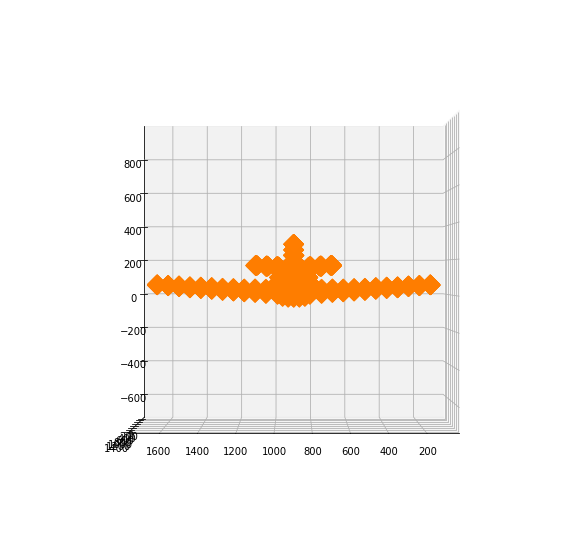

In [38]:
human_face = PyntCloud.from_file(
    "/home/alissa/IntelRealSense/bunny/data/top2.ply")
#print(human_face)

y = o3d.io.read_point_cloud("~/IntelRealSense/bunny/data/bun000.ply")
print(y)
#o3d.visualization.draw_geometries([y])

x = PyntCloud.from_file("airplane.ply")
print(x)
x.plot()

In [55]:
print("Testing IO for images ...")
img = o3d.io.read_point_cloud("1.ply")
print(img)

Testing IO for images ...
geometry::PointCloud with 83280 points.


In [56]:
def pairwise_registration(source, target):
    print("Apply point-to-plane ICP")
    icp_coarse = o3d.registration.registration_icp(
        source, target, max_correspondence_distance_coarse, np.identity(4),
        o3d.registration.TransformationEstimationPointToPlane())
    icp_fine = o3d.registration.registration_icp(
        source, target, max_correspondence_distance_fine,
        icp_coarse.transformation,
        o3d.registration.TransformationEstimationPointToPlane())
    transformation_icp = icp_fine.transformation
    information_icp = o3d.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp

In [57]:
def full_registration(pcds, max_correspondence_distance_coarse,
                      max_correspondence_distance_fine):
    pose_graph = o3d.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)
    for source_id in range(n_pcds):
        for target_id in range(source_id + 1, n_pcds):
            transformation_icp, information_icp = pairwise_registration(
                pcds[source_id], pcds[target_id])
            print("Build o3d.registration.PoseGraph")
            if target_id == source_id + 1:  # odometry case
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    o3d.registration.PoseGraphNode(np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    o3d.registration.PoseGraphEdge(source_id,
                                                   target_id,
                                                   transformation_icp,
                                                   information_icp,
                                                   uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.registration.PoseGraphEdge(source_id,
                                                   target_id,
                                                   transformation_icp,
                                                   information_icp,
                                                   uncertain=True))
    return pose_graph



In [58]:
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Debug)
pcds_down = load_point_clouds(voxel_size)
o3d.visualization.draw_geometries(pcds_down)

In [59]:
pcds_down

[geometry::PointCloud with 1333 points., geometry::PointCloud with 0 points.]

In [60]:
print("Full registration ...")
pose_graph = full_registration(pcds_down,                                
                           max_correspondence_distance_coarse,                             
                           max_correspondence_distance_fine)

Full registration ...
Apply point-to-plane ICP
Build o3d.registration.PoseGraph


In [61]:
print("Optimizing PoseGraph ...")
option = o3d.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0)
o3d.registration.global_optimization(
    pose_graph, o3d.registration.GlobalOptimizationLevenbergMarquardt(),
    o3d.registration.GlobalOptimizationConvergenceCriteria(), option)

Optimizing PoseGraph ...


In [62]:
print("Transform points and display")
for point_id in range(len(pcds_down)):
    print(pose_graph.nodes[point_id].pose)
    pcds_down[point_id].transform(pose_graph.nodes[point_id].pose)
o3d.visualization.draw_geometries(pcds_down)

Transform points and display
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [63]:
print("Make a combined point cloud")
pcds = load_point_clouds(voxel_size)
pcd_combined = o3d.geometry.PointCloud()
for point_id in range(len(pcds)):
    pcds[point_id].transform(pose_graph.nodes[point_id].pose)
    pcd_combined += pcds[point_id]
#pcd_combined_down = pcd_combined.voxel_down_sample(voxel_size=voxel_size)
pcd_combined_down = o3d.geometry.voxel_down_sample(pcd_combined, voxel_size = voxel_size)

o3d.io.write_point_cloud("multiway_registration.pcd", pcd_combined_down)
o3d.visualization.draw_geometries([pcd_combined_down])

Make a combined point cloud
